<a href="https://colab.research.google.com/github/UgurUysal86/My-ML-Notebooks/blob/main/classification-structured-data/ex-1/20230813_Training_a_classification_model_on_the_spambase_dataset_to_predict_if_an_email_is_spam_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Ugur Uysal](https://github.com/UgurUysal86 ) - ugur.uysal.86@gmail.com - 13. AUG 2023
# Training a classification model on the spambase dataset to predict if an email is spam or not
The purpose of training a classifier on the Spambase dataset is to create a model that can accurately classify Email as Spam or Non-Spam. This notebook demonstrates the process of training a neural network-based classification model utilizing tensorflow.keras and Keras Tuner on the Spambase Data Set.

* Official public source of the dataset: http://archive.ics.uci.edu/dataset/94/spambase

# 0. Preparing the colab environment

## 0.1 Checking GPU availablity

The following code checks if a GPU is available for use in a Google Colab environment. It imports the TensorFlow library and the device_lib module, then iterates through the available devices to check for a GPU. If a GPU is found, its details are printed.

In [ ]:
import tensorflow as tf
print("Using Tensorflow Version", tf.__version__, "\n")

# validating COLAB GPU
from tensorflow.python.client import device_lib
for x in device_lib.list_local_devices():
   if x.device_type == "GPU":
     print("***** GPU Information *****")
     print("Device Name: " , x.name)
     print("Memory Limit: " , "%.2f" % float(x.memory_limit/(1000*1000*1000)), "GB")
     print("Description: " , x.physical_device_desc)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Using Tensorflow Version 2.12.0 

***** GPU Information *****
Device Name:  /device:GPU:0
Memory Limit:  14.33 GB
Description:  device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
Sun Aug 13 22:28:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |    387MiB / 15360MiB |      5%      Default |
|                               |          

## 0.2 Importing more python packages used for this notebook

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.manifold import TSNE

# 1. Downloading and preprocessing the dataset

## 1.1. Downloading the dataset
The following code downloads the Dataset from its original source and saves it in the Colab environment.

In [ ]:
# Downloading the spambase dataset and saving temporary in Colab
print ("Loading dataset ...")
!wget --no-check-certificate \
    "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data" \
    -O /tmp/spambase.data.csv

dataset_path = '/tmp/spambase.data.csv'
print ("Dataset successfully loaded")

Loading dataset ...
--2023-08-13 22:28:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/tmp/spambase.data.csv’

/tmp/spambase.data.     [ <=>                ] 686.47K  --.-KB/s    in 0.1s    

2023-08-13 22:28:31 (5.03 MB/s) - ‘/tmp/spambase.data.csv’ saved [702942]

Dataset successfully loaded


## 1.2. Saving the dataset in a Pandas Dataframe

The following code reads the Spambase Data Set from the dataset_path variable into a Pandas DataFrame called spambase_df. The read_csv function from Pandas to read the dataset from the file specified by dataset_path into a DataFrame. The last line of code uses the head function to display the first 5 rows of the DataFrame.

In [ ]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names
col_names = ['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over','word_freq_remove',	'word_freq_internet','word_freq_order','word_freq_mail',
             'word_freq_receive','word_freq_will','word_freq_people','word_freq_report',	'word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you','word_freq_credit',
             'word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs',	'word_freq_telnet',
             'word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts',	'word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting',
             'word_freq_original','word_freq_project','word_freq_re','word_freq_edu',	'word_freq_table','word_freq_conference','char_freq_;','char_freq_(','char_freq_[','char_freq_!','char_freq_$','char_freq_#',
             'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total','label']

class_names = ['Non-Spam', 'Spam'] # denotes whether the e-mail was considered Non-Spam (0) or spam (1)

# Loading and Exploring the dataset
spambase_df = pd.read_csv(dataset_path, header=None, names=col_names)
spambase_df.sample(5)

## 1.3. Analysis of the dataset

The following code defines a function called quick_analysis that takes a Pandas DataFrame as an input and prints out various summary statistics about the data. The function prints the data types of each column, the number of rows and columns, the index range, the column names, the number of null values in each column, the mean value of each column, and the standard deviation of each column.

The last line of code calls the quick_analysis function on the spambase_df DataFrame to display summary statistics about the Spambase Dataset.

In [ ]:
# Quick analysis of the dataset
def quick_analysis(df):
    print("Data Types:")
    print(df.dtypes)
    print("\nNumber of Rows and Columns:")
    print(df.shape)
    print("\nIndex Range:")
    print(df.index)
    print("\nColumn Names:")
    print(df.columns)
    print("\nNumber of Null Values:")
    print(df.isnull().sum())
    print("\nMean Value:")
    print(df.mean())
    print("\nStd Deviation:")
    print(df.std())
quick_analysis(spambase_df)

Data Types:
word_freq_make                float64
word_freq_address             float64
word_freq_all                 float64
word_freq_3d                  float64
word_freq_our                 float64
word_freq_over                float64
word_freq_remove              float64
word_freq_internet            float64
word_freq_order               float64
word_freq_mail                float64
word_freq_receive             float64
word_freq_will                float64
word_freq_people              float64
word_freq_report              float64
word_freq_addresses           float64
word_freq_free                float64
word_freq_business            float64
word_freq_email               float64
word_freq_you                 float64
word_freq_credit              float64
word_freq_your                float64
word_freq_font                float64
word_freq_000                 float64
word_freq_money               float64
word_freq_hp                  float64
word_freq_hpl                 float64


##1.4. One-Hot Encoding the Subject Column

The following code performs one-hot encoding on the subject column of the spambase_df DataFrame. The map function is used to replace the values in the label column with strings the Non-Spam and 'Spam'. The get_dummies function from Pandas is then used to perform one-hot encoding on the subject column. The resulting DataFrame has a new column for each unique value in the original label column. The last line of code uses the sample function to display a random sample of 5 rows from the resulting DataFrame.

In [ ]:
# One Hot encoding the labels
spambase_df['label'] = spambase_df['label'].map({0: class_names[0], 1: class_names[1]})  # class_names=['Non-Spam', 'Spam'] # denotes whether the e-mail was considered Non-Spam (0) or spam (1)
spambase_df = pd.get_dummies(spambase_df, columns=['label'], prefix='', prefix_sep='')
spambase_df.sample(5)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Non-Spam,Spam
355,0.00,0.00,1.31,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.0,0.000,0.201,0.000,4.500,25,54,0,1
4188,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.102,0.0,0.000,0.000,0.000,3.400,51,119,1,0
1208,0.47,0.31,0.47,0.0,0.05,0.15,0.05,0.23,0.44,0.76,...,0.068,0.0,0.344,0.784,0.154,6.094,193,3029,0,1
1662,0.14,0.18,0.79,0.0,0.04,0.14,0.18,0.28,0.28,0.84,...,0.101,0.0,0.522,0.109,0.062,5.759,116,2062,0,1
3724,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.0,0.000,0.000,0.000,2.333,8,28,1,0


## 1.5. Separating Targets from Features

The following code separates the target values from the feature values in the spambase_df DataFrame. The features variable is assigned the values of specific columns in the DataFrame using the loc function. These columns represent the features used to make predictions.

The targets variable is assigned the values of specific columns in the DataFrame using the loc function. These columns represent the target values that the model will try to predict.

The last few lines of code print out information about the features and targets variables, including their data types and shapes.

In [ ]:
# separating targets from features
features = spambase_df.iloc[:,:57].values # The first 57 columns are features (x)
targets  = spambase_df.iloc[:,57:].values # The last 2 columns has the one hot encoded labels (y)

print('features:\n',type(features))
print(np.shape(features))
print('\ntargets:\n',type(targets))
print(np.shape(targets))

print('\nThe class distribution of the spambase dataset (',class_names[0],',',class_names[1],') is (', len(spambase_df[spambase_df['Non-Spam']==1]), ',', len(spambase_df[spambase_df['Spam']==1]), ')')

features:
 <class 'numpy.ndarray'>
(4601, 57)

targets:
 <class 'numpy.ndarray'>
(4601, 2)

The class distribution of the spambase dataset ( Non-Spam , Spam ) is ( 2788 , 1813 )


## 1.6. Standardizing Features and Splitting Data into Training and Test Sets

The folowing code standardizes the features array and splits the data into training and test sets.

First, the train_test_split and StandardScaler functions are imported from the sklearn library. Then, a StandardScaler object is created and used to standardize the features array by calling its fit_transform method. This method calculates the mean and standard deviation of each feature in the training data, then scales the data by subtracting the mean and dividing by the standard deviation. The resulting standardized features are stored in a new variable called features_standardized.

Next, the train_test_split function is used to split the standardized features and targets into training and test sets. The test set size is specified as 10% of the total data, and a random state is set for reproducibility. The resulting training and test sets for both features and targets are stored in separate variables.

Finally, the shapes of the training and test sets for both features and targets are printed to show their dimensions.

In [ ]:
# preprocessing - standardize the features array using sklearn standard scaler
standardizer = StandardScaler()
features_standardized = standardizer.fit_transform(features)

# Split data into training and test set
train_x, test_x, train_y, test_y = train_test_split(features_standardized, targets, test_size=0.1, random_state=0)
print('train_x.shape', train_x.shape)
print('train_y.shape', train_y.shape)
print('test_x.shape', test_x.shape)
print('test_y.shape', test_y.shape)

train_x.shape (4140, 57)
train_y.shape (4140, 2)
test_x.shape (461, 57)
test_y.shape (461, 2)


# 2. Training a baseline model

Starting with a simple baseline model provides a point of reference for evaluating the more complex model which will be trained in the following section. The baseline model helps to identify issues early on, and ensures that added complexity is justified by an improvement in performance.

## 2.1. Training a k-nearest neighbors classifier and predicting labels of the testset
The following code uses a k-nearest neighbors (K-NN) classifier from the scikit-learn library to train a model and make predictions on the test set. The code is iterating over a range of values for the n_neighbors parameter, which specifies the number of nearest neighbors to include in the majority voting process. For each value of n_neighbors, a KNeighborsClassifier object is created and trained on the training data train_x and train_y. Then, the classifier is used to predict the labels for the test data test_x. The accuracy of the predictions is calculated by comparing the predicted labels to the true labels test_y using the accuracy_score function. Finally, the accuracy score for each value of n_neighbors is printed.


In [ ]:
# Finding the best value for n_neighbors to train the k-nearest neighbors classifier
for i in range(1,11):
  classifier = KNeighborsClassifier(n_neighbors = i)
  classifier.fit(train_x, train_y)
  predicted_labels = classifier.predict(test_x)
  score = accuracy_score(test_y, predicted_labels)
  print('The Accuracy_score of the KNeighborsClassifier for n_neighbors =', i, 'is', score)

The Accuracy_score of the KNeighborsClassifier for n_neighbors = 1 is 0.93058568329718
The Accuracy_score of the KNeighborsClassifier for n_neighbors = 2 is 0.8633405639913232
The Accuracy_score of the KNeighborsClassifier for n_neighbors = 3 is 0.9327548806941431
The Accuracy_score of the KNeighborsClassifier for n_neighbors = 4 is 0.89587852494577
The Accuracy_score of the KNeighborsClassifier for n_neighbors = 5 is 0.928416485900217
The Accuracy_score of the KNeighborsClassifier for n_neighbors = 6 is 0.9067245119305857
The Accuracy_score of the KNeighborsClassifier for n_neighbors = 7 is 0.9197396963123644
The Accuracy_score of the KNeighborsClassifier for n_neighbors = 8 is 0.8980477223427332
The Accuracy_score of the KNeighborsClassifier for n_neighbors = 9 is 0.9240780911062907
The Accuracy_score of the KNeighborsClassifier for n_neighbors = 10 is 0.8937093275488069


In [ ]:
# Using the best value for n_neighbors to train the k-nearest neighbors classifier
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(train_x, train_y)
predicted_labels = classifier.predict(test_x)
print('The Accuracy_score of the KNeighborsClassifier is', accuracy_score(test_y, predicted_labels))

The Accuracy_score of the KNeighborsClassifier is 0.9327548806941431


## 2.2. Evaluating the performance of the k-nearest neighbors classifier

The following code evaluates the performance of the trained k-nearest neighbors classifier on the test data using various performance metrics from the scikit-learn library.




Confusion matrix


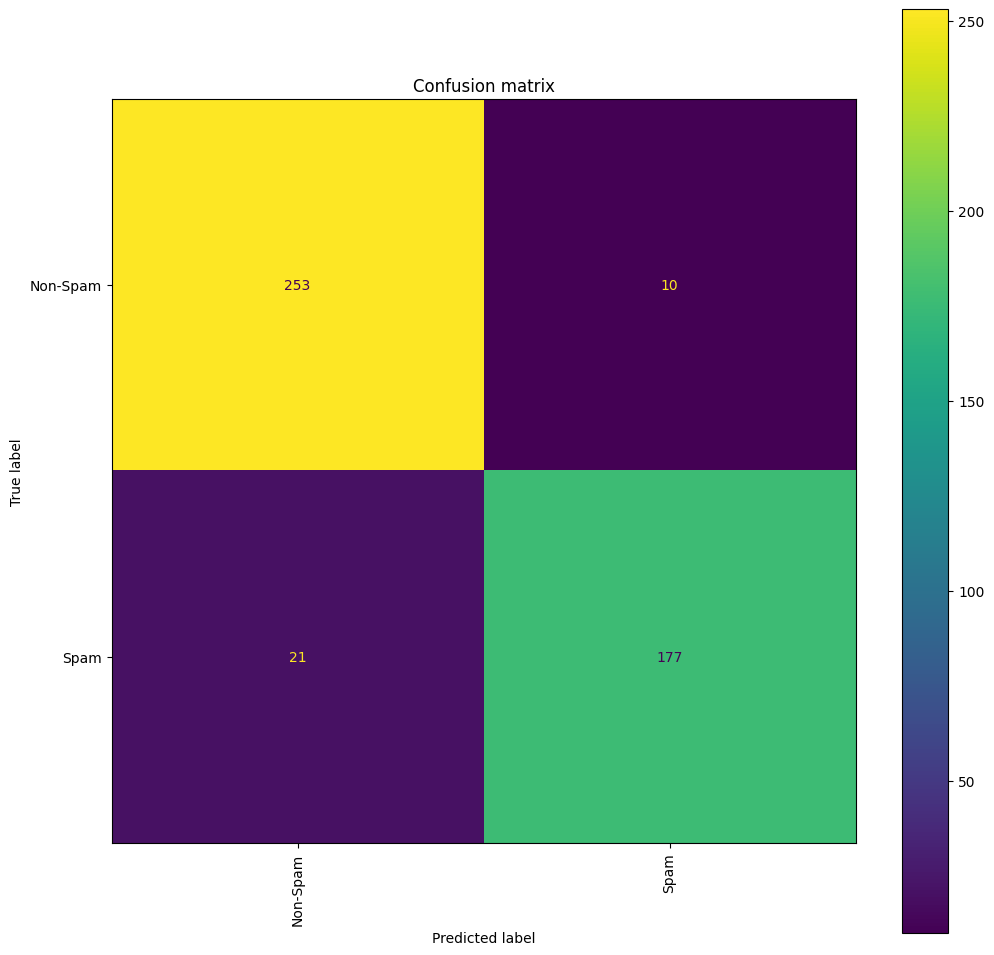

In [ ]:
print('\nConfusion matrix')
plt.rcParams['figure.figsize'] = [12, 12]
ConfusionMatrixDisplay.from_predictions(test_y.argmax(axis=1), predicted_labels.argmax(axis=1), display_labels=class_names, xticks_rotation='vertical')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print('\nClassification Report')
print(classification_report(test_y.argmax(axis=1), predicted_labels.argmax(axis=1), target_names=class_names))


Classification Report
              precision    recall  f1-score   support

    Non-Spam       0.92      0.96      0.94       263
        Spam       0.95      0.89      0.92       198

    accuracy                           0.93       461
   macro avg       0.93      0.93      0.93       461
weighted avg       0.93      0.93      0.93       461



The baseline model already achieves an accuracy of 93% on the test set with minimal computational effort. To improve the classification accuracy, a neural network will be trained using TensorFlow’s Keras API in the following sections.

# 3. Training a model using TensorFlow’s Keras

## 3.1. Setting up the keras_tuner package for hyperparameter tuning of the tf.keras model.

Go directly to section 3.4 from where on the model will manually defined based on the results of the keras tuner" if you want to skip the keras tuner part.

In [ ]:
%pip install keras_tuner

## 3.2. Building a Neural Network Model with Keras Tuner
The following code uses Keras Tuner to find the best architecture for a neural network model. It defines a model_builder function that takes hyperparameters as input and returns a compiled Keras model. The function constructs a sequential model with a variable number of dense layers, batch normalization, and dropout. The learning rate and dropout rate are also hyperparameters. The function is then called with an instance of kt.HyperParameters to build a model.

In [ ]:
# finding the best model architecture with keras tuner within a given model structure
import keras_tuner as kt

def model_builder(hp):
    tuner_model = tf.keras.Sequential()
    tuner_model.add(tf.keras.layers.Flatten(input_shape=(train_x.shape[1],)))

    for i in range(hp.Int('num_layers', 1, 3)):
        tuner_model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32),activation=tf.nn.relu))
        tuner_model.add(tf.keras.layers.BatchNormalization())
        tuner_model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.4, step=0.1)))

    tuner_model.add(tf.keras.layers.Dense(train_y.shape[1],  activation=tf.nn.softmax))

    hp_learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.001, sampling='log')

    tuner_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

    return tuner_model

model_builder(kt.HyperParameters())

## 3.3. Tuning the Neural Network Model with Keras Tuner using RandomSearch
The following code creates an instance of the RandomSearch class from Keras Tuner to perform random search for hyperparameter optimization. It specifies the model-building function, the metric to optimize, the maximum number of trials, and where to save the results.

Then this code performs hyperparameter tuning using the tuner object created. It defines an early stopping callback to stop training if the validation accuracy does not improve for 5 epochs. The search method is called on the tuner object to perform the hyperparameter search, using the training data and validation split. The best hyperparameters are then retrieved and printed.

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=model_builder,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory="spambase",
    project_name="spambase")

BATCHSIZE = 256
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
tuner.search(train_x, train_y, epochs=100, validation_split=0.1, batch_size=BATCHSIZE, callbacks=[early_stop])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of densely-connected layers is {best_hps.get('num_layers')},
The optimal number of units in the densely-connected layers is {best_hps.get('units')},
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')},
the optimal dropout rate for the model is {best_hps.get('dropout_rate')}.
""")

Trial 100 Complete [00h 00m 08s]
val_accuracy: 0.9444444179534912

Best val_accuracy So Far: 0.966183602809906
Total elapsed time: 00h 13m 15s

The hyperparameter search is complete.
The optimal number of densely-connected layers is 2,
The optimal number of units in the densely-connected layers is 192,
the optimal learning rate for the optimizer is 0.0005702538801893047,
the optimal dropout rate for the model is 0.1.



The following code retrieves the best model architecture found by a RandomSearch tuner and assigns it to the variable RandomSearch_model. The summary method is then called on this model to display a summary of its architecture.

In [ ]:
# checking the best found model architecture with RandomSearch
models = tuner.get_best_models(num_models=1)
RandomSearch_model = models[0]
RandomSearch_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 57)                0         
                                                                 
 dense (Dense)               (None, 192)               11136     
                                                                 
 batch_normalization (BatchN  (None, 192)              768       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 192)               37056     
                                                                 
 batch_normalization_1 (Batc  (None, 192)              768       
 hNormalization)                                        

This code evaluates the performance of the trained RandomSearch_model on a test dataset with inputs test_x and labels test_y. The evaluate method returns the test loss and test accuracy, which are then printed to the console.

In [ ]:
# testing the trained RandomSearch model
test_loss, test_acc = RandomSearch_model.evaluate(test_x, test_y, verbose=1)
print ("\ntest loss:", test_loss, ", \ntest accuracy:", test_acc)

15/15 [==============================] - 0s 4ms/step - loss: 0.1658 - accuracy: 0.9349

test loss: 0.16577845811843872 , 
test accuracy: 0.9349240660667419


The model found with keras tuner's RandomSearch with 100 trials achieves an accuracy of 94.8% on the test set. To improve the classification accuracy, the neural network could be trained with much more trials or using the hyperband algorythm.

## 3.4. Defining more precise metrics for the final model

The following code defines a list of metrics to be used when evaluating the classification model. The metrics include true positives, false positives, true negatives, false negatives, accuracy, precision and recall.

In [ ]:
# Remember: Recall is the correct metric to choose when minimizing false negatives is critical.
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

## 3.5. Defining the model manually based on the results of the keras tuner
The following code defines a function createmodel that takes a learning rate as input and returns a compiled Keras model. The function constructs a sequential model with three dense layers, batch normalization, and dropout. The model is compiled with the RMSprop optimizer, binary cross-entropy loss, and the metrics defined earlier. The model summary is printed before returning the model.

In [ ]:
# function to build the model manually
def createmodel(lr):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(192, activation=tf.nn.relu, input_shape=(train_x.shape[1],)))      # number features
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(192, activation=tf.nn.relu))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(train_y.shape[1], activation=tf.nn.softmax))       # number targets one hot encoded 'Non-Spam', 'Spam'
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr), loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)
    return model

## 3.6. Defining Hyperparameters, Callbacks, and Creating the Model
The following code defines hyperparameters for training a model, including the number of epochs, batch size, and learning rate. It also defines two callbacks: early stopping and reduce learning rate on plateau. The createmodel function is called with the specified learning rate to create a model. The model architecture is then plotted using the plot_model function from Keras.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 192)               11136     
                                                                 
 batch_normalization (BatchN  (None, 192)              768       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 192)               37056     
                                                                 
 batch_normalization_1 (Batc  (None, 192)              768       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 192)               0

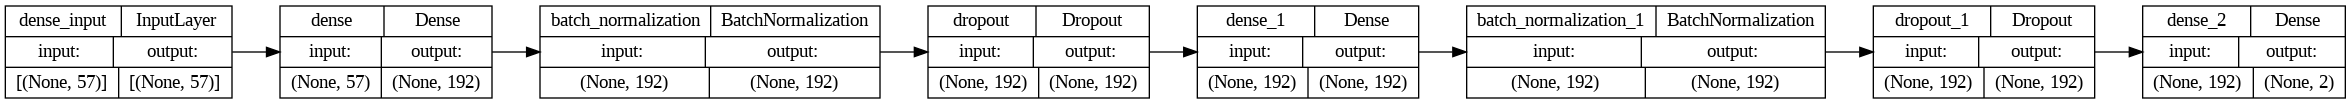

In [ ]:
# Hyperparameters
EPOCHS = 1000
LEARNING_RATE = 0.0005

#callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=9, verbose=0)

# clearing the session from previous models and layers
tf.keras.backend.clear_session()  # this helps avoid clutter from old models and layers

#create the model
model = createmodel(LEARNING_RATE)
model.summary()

#plotting the model
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## 3.7. Optimizing the batch size for the final training of the model

The Batch size is a parameter that determines the number of samples used to update the model in each iteration. The batch sizes used are 16, 32, 64, 128. tf.keras uses by default 32 as batch size if not defined specifically. For each batch size, the code creates a new model, trains it on 100 % the training data, and validates its performance directly on the test data. The loss, accuracy, precision, and recall are printed for each batch size.

In [ ]:
BATCHSIZES = [16,32,64,128]
for i in range (len(BATCHSIZES)):
  print('\n Training the model with batch_size =',BATCHSIZES[i])
  tf.keras.backend.clear_session()
  model = createmodel(LEARNING_RATE)
  model.fit(train_x, train_y, epochs=EPOCHS, validation_data=(test_x, test_y), batch_size=BATCHSIZES[i], verbose=0, callbacks=[early_stop,reduce_lr])
  loss, accuracy, precision, recall = model.evaluate(test_x, test_y, verbose=0)
  print ('Results for batch_size', BATCHSIZES[i], ': \n test loss:', loss, '\n test accuracy:', accuracy, '\n test precision:', precision , '\n test recall:', recall)


 Training the model with batch_size = 16
Restoring model weights from the end of the best epoch: 18.
Epoch 38: early stopping
Results for batch_size 16 : 
 test loss: 0.16938981413841248 
 test accuracy: 0.9479392766952515 
 test precision: 0.9479392766952515 
 test recall: 0.9479392766952515

 Training the model with batch_size = 32
Restoring model weights from the end of the best epoch: 33.
Epoch 53: early stopping
Results for batch_size 32 : 
 test loss: 0.182560995221138 
 test accuracy: 0.9544468522071838 
 test precision: 0.9544468522071838 
 test recall: 0.9544468522071838

 Training the model with batch_size = 64
Restoring model weights from the end of the best epoch: 31.
Epoch 51: early stopping
Results for batch_size 64 : 
 test loss: 0.1840265542268753 
 test accuracy: 0.9479392766952515 
 test precision: 0.9479392766952515 
 test recall: 0.9479392766952515

 Training the model with batch_size = 128
Restoring model weights from the end of the best epoch: 31.
Epoch 51: early

## 3.8. Training the final model
The following code trains the model on the training data train_x and train_y using the fit method. The number of epochs, validation data, batch size, and verbosity are specified using the hyperparameters defined earlier. The early stopping and reduce learning rate on plateau callbacks are also passed to the fit method. The training history is returned and stored in the history variable. 100 % of the training data is now used for training since there is no validation split but instead the test set is directly used for validation.

In [ ]:
BATCHSIZE = 32
tf.keras.backend.clear_session()
model = createmodel(LEARNING_RATE)
history = model.fit(train_x, train_y, epochs=EPOCHS, validation_data=(test_x, test_y), batch_size=BATCHSIZE, verbose=2, callbacks=[early_stop,reduce_lr])

Epoch 1/1000
130/130 - 8s - loss: 0.3543 - accuracy: 0.8648 - precision: 0.8648 - recall: 0.8648 - val_loss: 0.2647 - val_accuracy: 0.9219 - val_precision: 0.9219 - val_recall: 0.9219 - lr: 5.0000e-04 - 8s/epoch - 60ms/step
Epoch 2/1000
130/130 - 1s - loss: 0.2268 - accuracy: 0.9171 - precision: 0.9171 - recall: 0.9171 - val_loss: 0.1929 - val_accuracy: 0.9284 - val_precision: 0.9284 - val_recall: 0.9284 - lr: 5.0000e-04 - 668ms/epoch - 5ms/step
Epoch 3/1000
130/130 - 1s - loss: 0.2048 - accuracy: 0.9297 - precision: 0.9297 - recall: 0.9297 - val_loss: 0.1788 - val_accuracy: 0.9371 - val_precision: 0.9371 - val_recall: 0.9371 - lr: 5.0000e-04 - 646ms/epoch - 5ms/step
Epoch 4/1000
130/130 - 1s - loss: 0.1840 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - val_loss: 0.1657 - val_accuracy: 0.9393 - val_precision: 0.9393 - val_recall: 0.9393 - lr: 5.0000e-04 - 635ms/epoch - 5ms/step
Epoch 5/1000
130/130 - 1s - loss: 0.1715 - accuracy: 0.9379 - precision: 0.9379 - recall: 0.9379 -

## 3.9. Testing the final model
The following code evaluates the trained model on the test data test_x and test_y using the evaluate method. The method returns the loss and the values of the metrics specified earlier, including true positives, false positives, true negatives, false negatives, accuracy, precision and recall. These values are unpacked into separate variables. The test loss, accuracy, and recall are then printed.

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_x, test_y, verbose=1)
print ('\n test loss:', loss, '\n test accuracy:', accuracy, '\n test precision:', precision , '\n test recall:', recall)

15/15 [==============================] - 0s 3ms/step - loss: 0.1720 - accuracy: 0.9523 - precision: 0.9523 - recall: 0.9523

 test loss: 0.17197057604789734 
 test accuracy: 0.952277660369873 
 test precision: 0.952277660369873 
 test recall: 0.952277660369873


## 3.10. Plotting Training and Validation Metrics per Epoch
The following code uses the history object returned by the fit method to extract the training and validation accuracy, loss, recall, and false negatives for each epoch. It then uses the pyplot module from matplotlib to plot the training and validation accuracy, loss, and recall per epoch. Three separate plots are created, one for accuracy, one for loss, and one for recall.

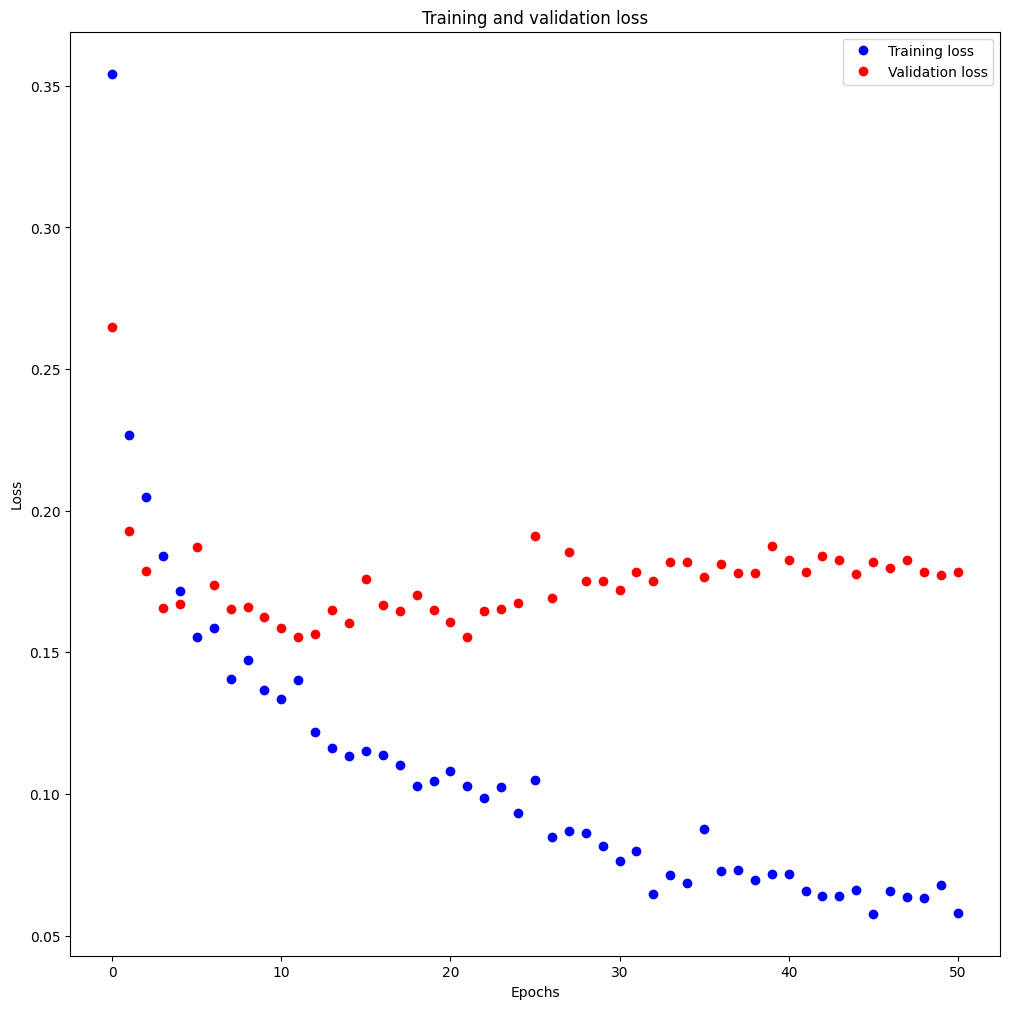

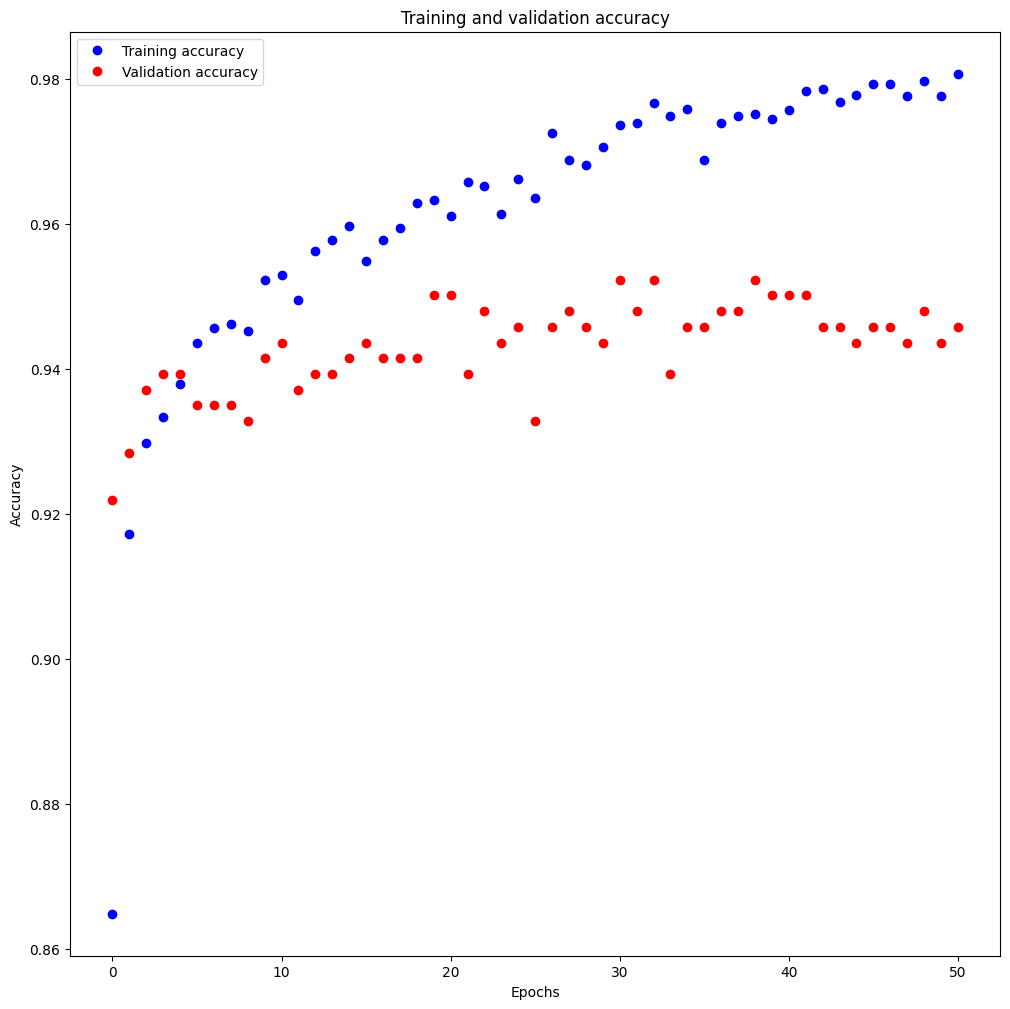

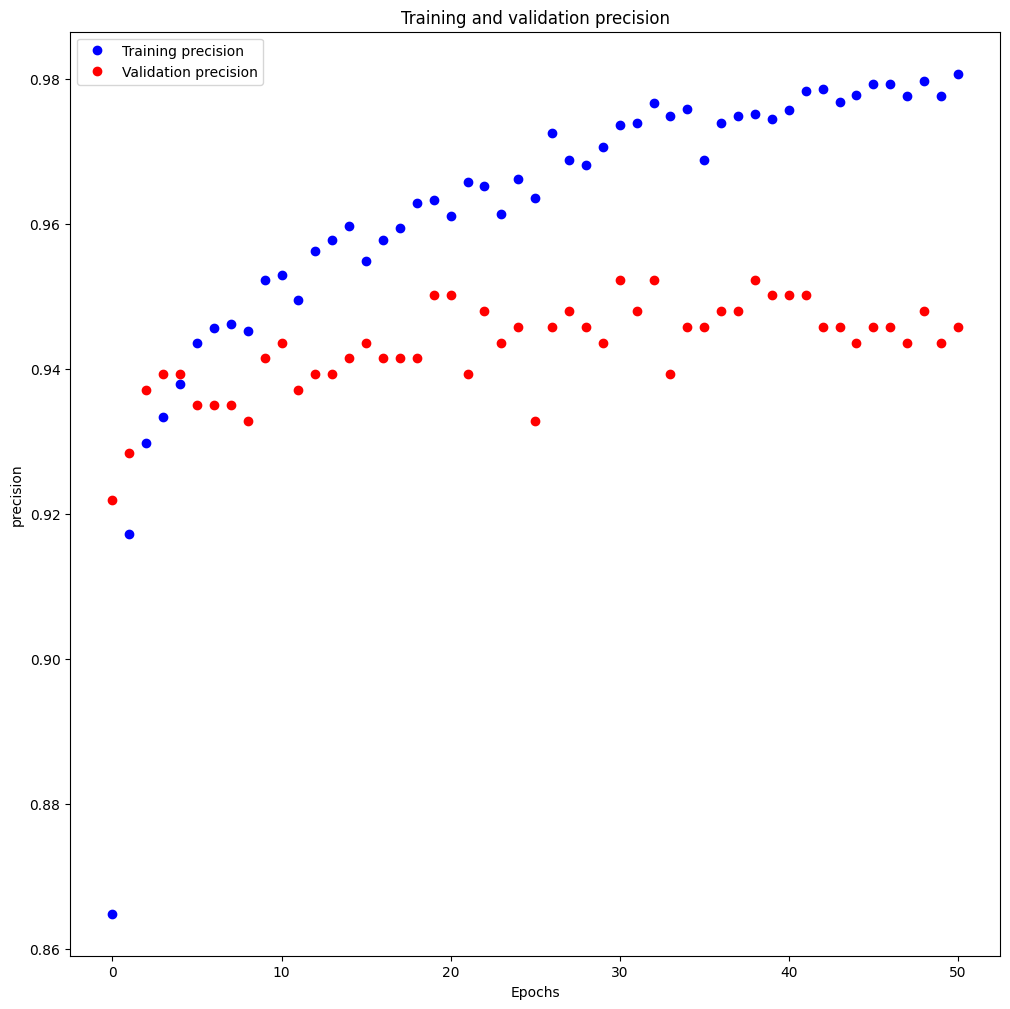

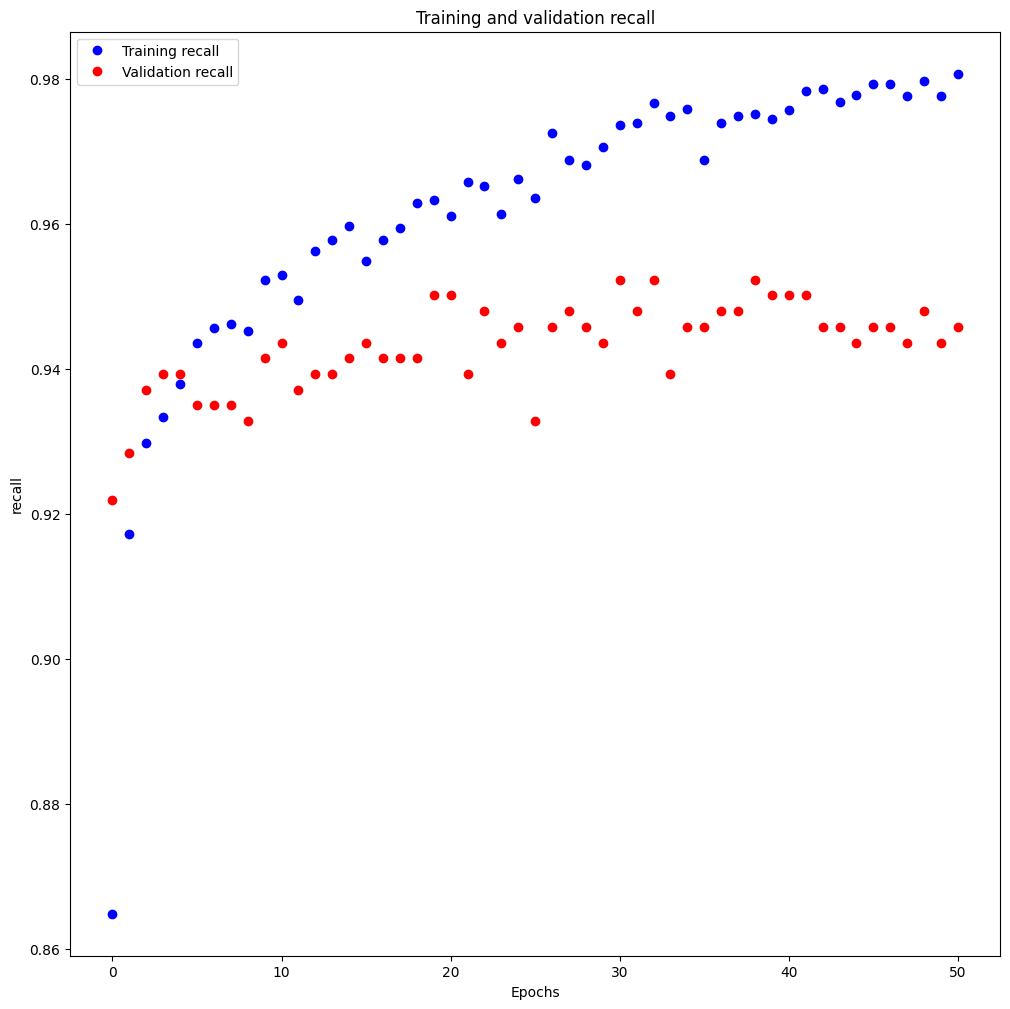

In [ ]:
# Evaluating Accuracy and Loss for the Model
loss          = history.history['loss' ]
val_loss      = history.history['val_loss']
accuracy      = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
precision     = history.history['precision']
val_precision = history.history['val_precision']
recall        = history.history['recall']
val_recall    = history.history['val_recall']

epochs = range(len(accuracy)) # Get number of epochs

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy per epoch
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation precision per epoch
plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'ro', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

# Plot training and validation recall per epoch
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'ro', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()

## 3.11. Evaluating the performance of the final model
The following code evaluates the performance of the trained classification model on the test data using various performance metrics from the scikit-learn library.

In [ ]:
# predicting all labels of the test set
predicted_labels = model.predict(test_x)

15/15 [==============================] - 0s 3ms/step


In [ ]:
print('The Accuracy_score of the final model is', accuracy_score(test_y.argmax(axis=1), predicted_labels.argmax(axis=1)))

The Accuracy_score of the final model is 0.9522776572668112



Confusion matrix


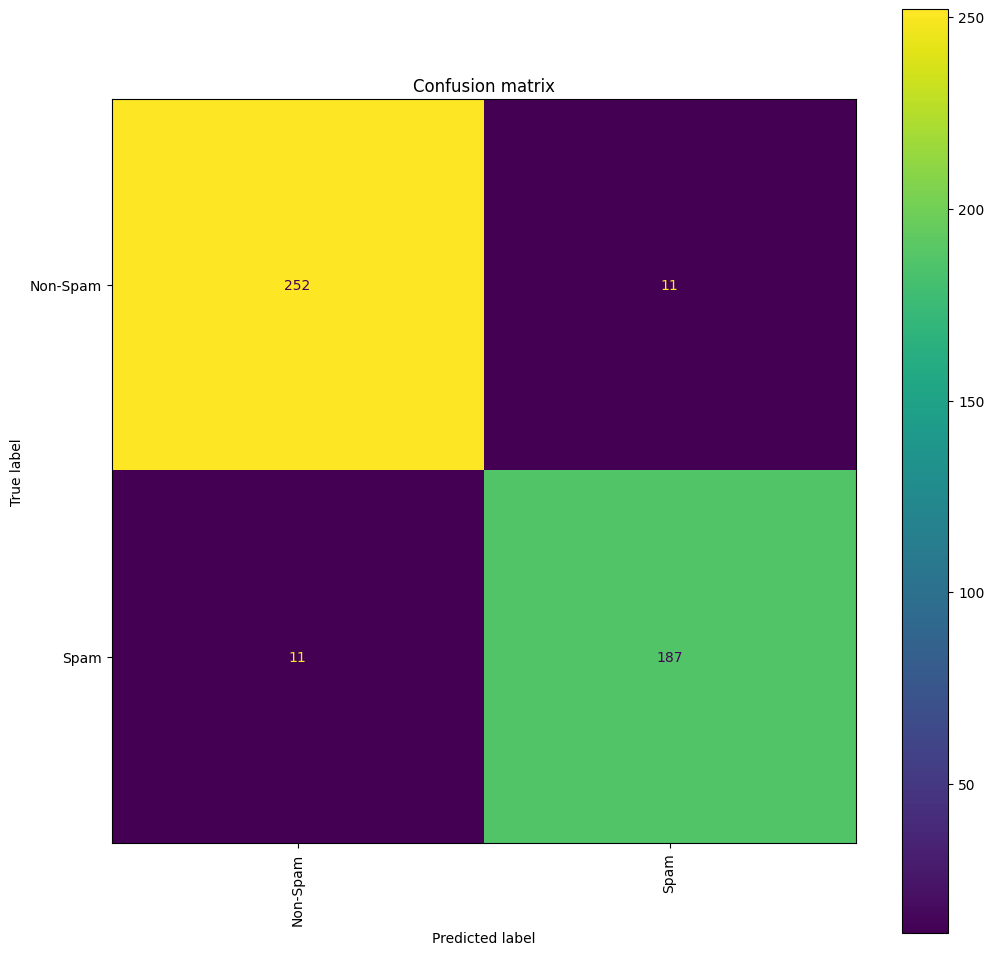

In [ ]:
print('\nConfusion matrix')
plt.rcParams['figure.figsize'] = [12, 12]
ConfusionMatrixDisplay.from_predictions(test_y.argmax(axis=1), predicted_labels.argmax(axis=1), display_labels=class_names, xticks_rotation='vertical')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print('\nClassification Report')
print(classification_report(test_y.argmax(axis=1), predicted_labels.argmax(axis=1), target_names=class_names))


Classification Report
              precision    recall  f1-score   support

    Non-Spam       0.96      0.96      0.96       263
        Spam       0.94      0.94      0.94       198

    accuracy                           0.95       461
   macro avg       0.95      0.95      0.95       461
weighted avg       0.95      0.95      0.95       461



The final model found with Keras Tuner achieves an accuracy of 96% on the test set. To improve the classification accuracy even further, the neural network could be modeled with more sophisticated layers such as LSTM layers instead of only using densely connected layers.

## 3.12. Visualizing the performance of the final model with t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a machine learning algorithm used for visualizing high-dimensional data. It maps the high-dimensional data to a lower-dimensional space (usually 2D or 3D) in a way that preserves the pairwise distances between the data points. This allows for the visualization of clusters and patterns in the data that may not be apparent in the high-dimensional space.

The following code uses t-SNE (t-Distributed Stochastic Neighbor Embedding) to visualize high-dimensional data. It first extracts the output of the last layer of a trained model and uses it to create an activation_model. This model is then used to generate activations for the test data. The activations are then transformed using t-SNE and plotted as a scatter plot with different colors representing different classes. The class names are also added to the plot as text labels.

15/15 [==============================] - 0s 2ms/step
activations.shape= (461, 2)
calculating t-SNE ... this may take some minutes depending on the size of the test set
t-SNE calculation finished


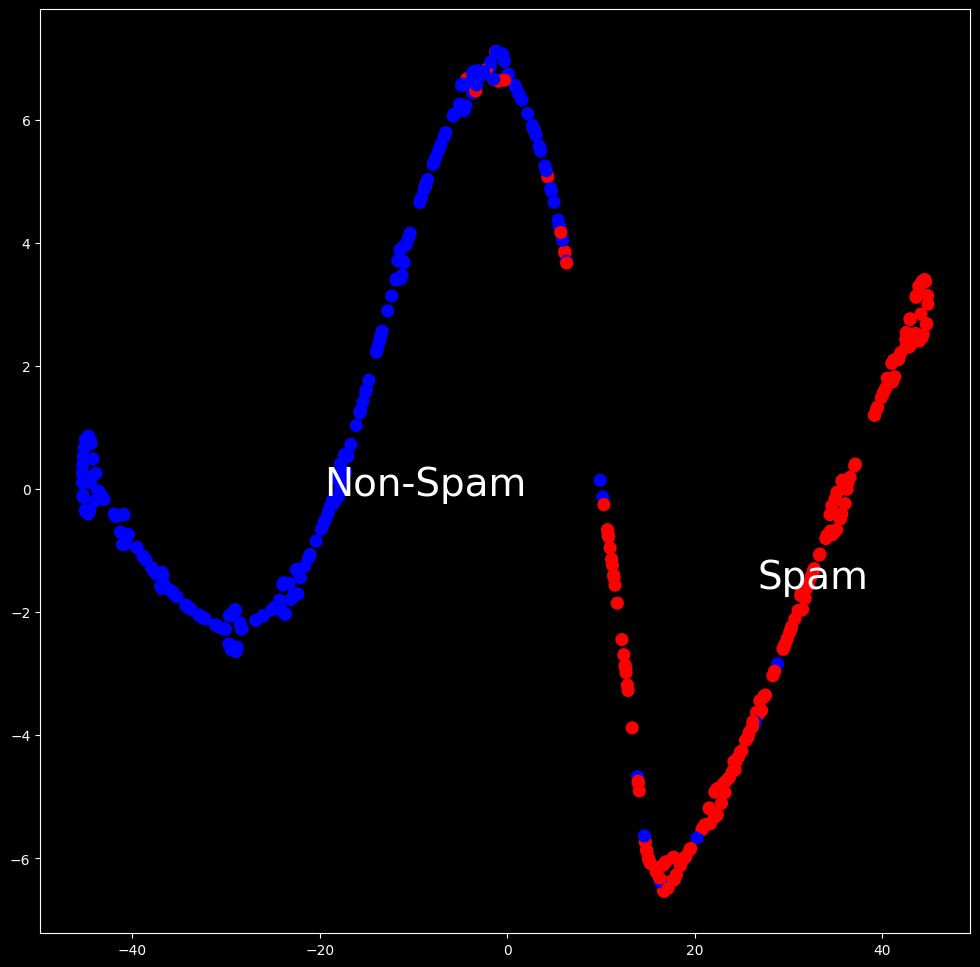

In [ ]:
# t-SNE Visualization: t-Distributed Stochastic Neighbor Embedding (t-SNE) for visualizing high-dimensional data.
from sklearn.manifold import TSNE
import seaborn as sns

layer = model.get_layer(index=len(model.layers)-1) # get last layer by index, use model.get_layer('dense_1') to get last layer by string.
layer_output = layer.output
activation_model = tf.keras.models.Model(inputs=model.input, outputs=[layer_output])
activations = activation_model.predict(test_x)
print("activations.shape=", activations.shape)

print("calculating t-SNE ... this may take some minutes depending on the size of the test set")
tsne = TSNE(random_state=86).fit_transform(activations)
print("t-SNE calculation finished")

# creating a scatter plot.
num_classes = len(class_names)
palette = np.array(sns.color_palette(["Blue","Red"] ,num_classes))  # manual selection of colors
label_array = np.asarray(test_y.argmax(axis=1))

fig = plt.figure(figsize=(12, 12))
fig.patch.set_facecolor('black')
plt.style.use('dark_background')
plt.scatter(tsne[:, 0], tsne[:, 1], lw=0, s=90, c=palette[label_array])
plt.axis('tight')

txts = []
for j in range(num_classes):
    # Position of each label at median of data points.
    xtext, ytext = np.median(tsne[label_array == j, :], axis=0)
    txt = plt.text(xtext, ytext, class_names[j], fontsize=28, color = 'w')
    txts.append(txt)
plt.show()

The t-SNE visualization clearly illustrates that both classes of the test set are well separated from each other, but some misclassification are still present.

# 4. Future Research
Further experiments with more special tf.keras models including Long Short-Term Memory layers (LSTM) could improve the model even more.

## 5. References:
* Official public source of the dataset: http://archive.ics.uci.edu/dataset/94/spambase

* TensorFlow Tutorial "Classification on imbalanced data" (https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

## License:
Copyright (c) 2023 Ugur Uysal

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Thank you. Visit my personal GitHub page https://github.com/UgurUysal86 for more examples.